In [ ]:
# Pre-process images with ResNet101 weights ported from VQA 1.0 Abstract Scene: https://visualqa.org/vqa_v2_download.html

In [ ]:
!git clone https://github.com/yossufyasser1/Visual-question-answering-model.git

Cloning into 'Visual-question-answering-model'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 8), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [ ]:
%cd /Visual-question-answering-model

/Visual-question-answering-model


In [ ]:
!pip install torch tqdm tensorflow  h5py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 157.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 135.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 142.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 148.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 135.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import h5py
from torch.autograd import Variable
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.models as models
from tqdm import tqdm

import config
import data
import utils
from resnet import resnet as caffe_resnet
import tensorflow as tf
import json
import os
import os.path
import re

from PIL import Image
import h5py
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from collections import Counter
import itertools
import config
import utils


2023-05-06 02:27:40.903948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 02:27:41.687988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.2 [168 kB]
Fetched 168 kB in 1s (277 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 15605 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.2_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.2) ...
Setting up unzip (6.0-21ubuntu1.2) ...
Processing triggers for mime-support (3.60ubuntu1) ...


In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/QUEStrain2014.zip', origin=_URL, extract=False,archive_format='auto')


7239401/7239401 [==============================] - 2s 0us/step


In [ ]:
fname = '/QUEStrain2014.zip'
!unzip -q $fname -d /Visual-question-answering-model/ 

In [ ]:
_URL = 'http://images.cocodataset.org/zips/train2014.zip'
zip_dir = tf.keras.utils.get_file('/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')


13510573713/13510573713 [==============================] - 584s 0us/step


In [ ]:
fname = '/MSCOCOVAL2014.zip'
!unzip -q $fname -d /Visual-question-answering-model/

In [ ]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/MSCOCOVAL12014.zip', origin=_URL, extract=False,archive_format='auto')


6645013297/6645013297 [==============================] - 308s 0us/step


In [ ]:
fname = '/MSCOCOVAL12014.zip'
!unzip -q $fname -d /Visual-question-answering-model/

In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/QUESVAL2014.zip'
!unzip -q $fname -d /Visual-question-answering-model/

3494929/3494929 [==============================] - 1s 0us/step


In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/ANNOTVAL2014.zip'
!unzip -q $fname -d /Visual-question-answering-model/

10518930/10518930 [==============================] - 3s 0us/step


In [ ]:
_URL = 'https://github.com/snagiri/ECE285_Jarvis_ProjectA/releases/download/v1.0/50epoch.pth'
zip_dir = tf.keras.utils.get_file('/Visual-question-answering-model/MSCOCOVAL2014.pth', origin=_URL, extract=False,archive_format='auto')

276298398/276298398 [==============================] - 1s 0us/step


In [ ]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/ANNOTTrain2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/ANNOTTrain2014.zip'
!unzip -q $fname -d /Visual-question-answering-model/

21708861/21708861 [==============================] - 11s 0us/step


In [ ]:
!apt-get install build-essential -y
!pip install pycocotools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-7 dirmngr
  dpkg-dev fakeroot g++ g++-7 gcc gcc-7 gcc-7-base gnupg gnupg-l10n
  gnupg-utils gpg-agent gpg-wks-client gpg-wks-server gpgsm
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libasan4 libatomic1 libbinutils libcc1-0 libcilkrts5 libdpkg-perl
  libfakeroot libfile-fcntllock-perl libgcc-7-dev libisl19 libitm1 libksba8
  liblocale-gettext-perl liblsan0 libmpc3 libmpfr6 libmpx2 libnpth0
  libquadmath0 libstdc++-7-dev libtsan0 libubsan0 make patch pinentry-curses
  xz-utils
Suggested packages:
  binutils-doc cpp-doc gcc-7-locales dbus-user-session libpam-systemd
  pinentry-gnome3 tor debian-keyring g++-multilib g++-7-multilib gcc-7-doc
  libstdc++6-7-dbg gcc-multilib manpages-dev autoconf automake libtool flex
  bison gdb gcc-doc gcc-7-multilib l

In [ ]:
import json
import os
import os.path
import re
from retinanet import model as retinanet
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer

from PIL import Image
import h5py
import torch
import torch.utils.data as tdata
import torchvision.transforms as transforms

import config
import utils
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
    transforms.Resize(int(target_size / central_fraction)),
    transforms.CenterCrop(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
    ])

def get_loader(train=False, val=False, test=False):
    """ Returns a data loader for the desired split """
    assert train + val + test == 1, 'need to set exactly one of {train, val, test} to True'
    split = VQA(
        path_for(train=train, val=val, test=test, question=True),
        path_for(train=train, val=val, test=test, answer=True),
        config.preprocessed_path,
        answerable_only=train,
    )
    loader = torch.utils.data.DataLoader(
        split,
        batch_size=config.batch_size,
        shuffle=train,  # only shuffle the data in training
        pin_memory=True,
        num_workers=config.data_workers,
        collate_fn=collate_fn,
    )
    return loader


def collate_fn(batch):
    # put question lengths in descending order so that we can use packed sequences later
    batch.sort(key=lambda x: x[-1], reverse=True)
    return tdata.dataloader.default_collate(batch)


class VQA(tdata.Dataset):
    """ VQA dataset, open-ended """
    def __init__(self, questions_path, answers_path, image_features_path, answerable_only=False):
        super(VQA, self).__init__()
        with open(questions_path, 'r') as fd:
            questions_json = json.load(fd)
        with open(answers_path, 'r') as fd:
            answers_json = json.load(fd)
        with open(config.vocabulary_path, 'r') as fd:
            vocab_json = json.load(fd)
        self._check_integrity(questions_json, answers_json)

        # vocab
        self.vocab = vocab_json
        self.token_to_index = self.vocab['question']
        self.answer_to_index = self.vocab['answer']

        # q and a
        self.questions = list(prepare_questions(questions_json))
        self.answers = list(prepare_answers(answers_json))
        self.questions = [self._encode_question(q) for q in self.questions]
        self.answers = [self._encode_answers(a) for a in self.answers]

        # v
        self.image_features_path = image_features_path
        self.coco_id_to_index = self._create_coco_id_to_index()
        self.coco_ids = [q['image_id'] for q in questions_json['questions']]

        # only use questions that have at least one answer?
        self.answerable_only = answerable_only
        if self.answerable_only:
            self.answerable = self._find_answerable()

    @property
    def max_question_length(self):
        if not hasattr(self, '_max_length'):
            self._max_length = max(map(len, self.questions))
        return self._max_length

    @property
    def num_tokens(self):
        return len(self.token_to_index) + 1  # add 1 for <unknown> token at index 0

    def _create_coco_id_to_index(self):
        """ Create a mapping from a COCO image id into the corresponding index into the h5 file """
        with h5py.File(self.image_features_path, 'r') as features_file:
            coco_ids = features_file['ids'][()]
        coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
        return coco_id_to_index

    def _check_integrity(self, questions, answers):
        """ Verify that we are using the correct data """
        qa_pairs = list(zip(questions['questions'], answers['annotations']))
        assert all(q['question_id'] == a['question_id'] for q, a in qa_pairs), 'Questions not aligned with answers'
        assert all(q['image_id'] == a['image_id'] for q, a in qa_pairs), 'Image id of question and answer don\'t match'
        assert questions['data_type'] == answers['data_type'], 'Mismatched data types'
        assert questions['data_subtype'] == answers['data_subtype'], 'Mismatched data subtypes'

    def _find_answerable(self):
        """ Create a list of indices into questions that will have at least one answer that is in the vocab """
        answerable = []
        for i, answers in enumerate(self.answers):
            answer_has_index = len(answers.nonzero()) > 0
            # store the indices of anything that is answerable
            if answer_has_index:
                answerable.append(i)
        return answerable

    def _encode_question(self, question):
        """ Turn a question into a vector of indices and a question length """
        vec = torch.zeros(self.max_question_length).long()
        for i, token in enumerate(question):
            index = self.token_to_index.get(token, 0)
            vec[i] = index
        return vec, len(question)

    def _encode_answers(self, answers):
        """ Turn an answer into a vector """
        # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
        # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
        # to get the loss that is weighted by how many humans gave that answer
        answer_vec = torch.zeros(len(self.answer_to_index))
        for answer in answers:
            index = self.answer_to_index.get(answer)
            if index is not None:
                answer_vec[index] += 1
        return answer_vec

    def _load_image(self, image_id):
        """ Load an image """
        if not hasattr(self, 'features_file'):
            # Loading the h5 file has to be done here and not in __init__ because when the DataLoader
            # forks for multiple works, every child would use the same file object and fail
            # Having multiple readers using different file objects is fine though, so we just init in here.
            self.features_file = h5py.File(self.image_features_path, 'r')
        index = self.coco_id_to_index[image_id]
        dataset = self.features_file['features']
        img = dataset[index].astype('float32')
        return torch.from_numpy(img)

    def __getitem__(self, item):
        if self.answerable_only:
            # change of indices to only address answerable questions
            item = self.answerable[item]

        q, q_length = self.questions[item]
        a = self.answers[item]
        image_id = self.coco_ids[item]
        v = self._load_image(image_id)
        # since batches are re-ordered for PackedSequence's, the original question order is lost
        # we return `item` so that the order of (v, q, a) triples can be restored if desired
        # without shuffling in the dataloader, these will be in the order that they appear in the q and a json's.
        return v, q, a, item, q_length

    def __len__(self):
        if self.answerable_only:
            return len(self.answerable)
        else:
            return len(self.questions)


# this is used for normalizing questions
_special_chars = re.compile('[^a-z0-9 ]*')

# these try to emulate the original normalization scheme for answers
_period_strip = re.compile(r'(?!<=\d)(\.)(?!\d)')
_comma_strip = re.compile(r'(\d)(,)(\d)')
_punctuation_chars = re.escape(r';/[]"{}()=+\_-><@`,?!')
_punctuation = re.compile(r'([{}])'.format(re.escape(_punctuation_chars)))
_punctuation_with_a_space = re.compile(r'(?<= )([{0}])|([{0}])(?= )'.format(_punctuation_chars))


def prepare_questions(questions_json):
    """ Tokenize and normalize questions from a given question json in the usual VQA format. """
    questions = [q['question'] for q in questions_json['questions']]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')


def prepare_answers(answers_json):
    """ Normalize answers from a given answer json in the usual VQA format. """
    answers = [[a['answer'] for a in ans_dict['answers']] for ans_dict in answers_json['annotations']]
    # The only normalization that is applied to both machine generated answers as well as
    # ground truth answers is replacing most punctuation with space (see [0] and [1]).
    # Since potential machine generated answers are just taken from most common answers, applying the other
    # normalizations is not needed, assuming that the human answers are already normalized.
    # [0]: http://visualqa.org/evaluation.html
    # [1]: https://github.com/VT-vision-lab/VQA/blob/3849b1eae04a0ffd83f56ad6f70ebd0767e09e0f/PythonEvaluationTools/vqaEvaluation/vqaEval.py#L96

    def process_punctuation(s):
        # the original is somewhat broken, so things that look odd here might just be to mimic that behaviour
        # this version should be faster since we use re instead of repeated operations on str's
        if _punctuation.search(s) is None:
            return s
        s = _punctuation_with_a_space.sub('', s)
        if re.search(_comma_strip, s) is not None:
            s = s.replace(',', '')
        s = _punctuation.sub(' ', s)
        s = _period_strip.sub('', s)
        return s.strip()

    for answer_list in answers:
        yield list(map(process_punctuation, answer_list))


class CocoImages(tdata.Dataset):
    """ Dataset for MSCOCO images located in a folder on the filesystem """
    def __init__(self, path, transform=None):
        super(CocoImages, self).__init__()
        self.path = path
        self.id_to_filename = self._find_images()
        self.sorted_ids = sorted(self.id_to_filename.keys())  # used for deterministic iteration order
        print('found {} images in {}'.format(len(self), self.path))
        self.transform = transform

    def _find_images(self):
        id_to_filename = {}
        for filename in os.listdir(self.path):
            if not filename.endswith('.jpg'):
                continue
            id_and_extension = filename.split('_')[-1]
            id = int(id_and_extension.split('.')[0])
            id_to_filename[id] = filename
        return id_to_filename

    def __getitem__(self, item):
        id = self.sorted_ids[item]
        path = os.path.join(self.path, self.id_to_filename[id])
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        return id, img

    def __len__(self):
        return len(self.sorted_ids)


class Composite(tdata.Dataset):
    """ Dataset that is a composite of several Dataset objects. Useful for combining splits of a dataset. """
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, item):
        current = self.datasets[0]
        for d in self.datasets:
            if item < len(d):
                return d[item]
            item -= len(d)
        else:
            raise IndexError('Index too large for composite dataset')

    def __len__(self):
        return sum(map(len, self.datasets))


In [ ]:
pathimg = "/Visual-question-answering-model/train2014/"
pathimgval = "/Visual-question-answering-model/val2014"

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = retinanet.resnet101(80, pretrained=True)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer


def create_coco_loader(*paths):
    transform = get_transform(config.image_size, config.central_fraction)
    datasets = [CocoImages(path, transform=transform) for path in paths]
    train_data = CocoImages(paths[0])
    dataset = Composite(*datasets)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.preprocess_batch_size,
        num_workers=config.data_workers,
        shuffle=False,
        pin_memory=True,
    )
    return data_loader

cudnn.benchmark = True
from data import CocoImages
net = Net().cuda()
net.eval()

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [ ]:
train_data = CocoImages(pathimg)
#    loader = create_coco_loader(pathimg,pathimgval)

found 82783 images in /Visual-question-answering-model/train2014/


In [ ]:
pathes = [pathimg,pathimgval]
transform = get_transform(config.image_size, config.central_fraction)
datasets = [CocoImages(path, transform=transform) for path in pathes]

found 82783 images in /Visual-question-answering-model/train2014/
found 40504 images in /Visual-question-answering-model/val2014


In [ ]:
dataset = Composite(*datasets)


In [ ]:
data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.preprocess_batch_size,
        num_workers=config.data_workers,
        shuffle=False,
        pin_memory=True,
    )

In [ ]:
loader = data_loader

In [ ]:
# Pre-process vocabularies for questions and answers from VQA 2.0 Abstract Scene: https://visualqa.org/vqa_v1_download.html

In [ ]:
def extract_vocab(iterable, top_k=None, start=0):
    """ Turns an iterable of list of tokens into a vocabulary.
        These tokens could be single answers or word tokens in questions.
    """
    all_tokens = itertools.chain.from_iterable(iterable)
    counter = Counter(all_tokens)
    if top_k:
        most_common = counter.most_common(top_k)
        most_common = (t for t, c in most_common)
    else:
        most_common = counter.keys()
    # descending in count, then lexicographical order
    tokens = sorted(most_common, key=lambda x: (counter[x], x), reverse=True)
    vocab = {t: i for i, t in enumerate(tokens, start=start)}
    return vocab


In [ ]:
def path_for(train=False, val=False, test=False, question=False,answer =False):
    assert train + val + test == 1
    assert question + answer == 1
    assert not (test and answer), 'loading answers from test split not supported'  # if you want to eval on test, you need to implement loading of a VQA Dataset without given answers yourself
    if val and question:
        fmt = 'v2_OpenEnded_mscoco_val2014_questions.json'
    elif val and answer:
        fmt = 'v2_mscoco_val2014_annotations.json'
    elif answer and train:
        fmt = 'v2_mscoco_train2014_annotations.json'
    elif question and train:
        fmt = 'v2_OpenEnded_mscoco_train2014_questions.json'
    else:
        fmt = '{1}_{2}_annotations.json'
    s = fmt
    qa_path = '/Visual-question-answering-model'  # directory containing the question and annotation jsons
    return os.path.join(qa_path, s)

In [ ]:
   
    questions = path_for(train=True, question=True)
    answers = path_for(train=True, answer=True)

    with open(questions, 'r') as fd:
        questions = json.load(fd)
    with open(answers, 'r') as fd:
        answers = json.load(fd)

    questions = prepare_questions(questions)
    answers = prepare_answers(answers)

    question_vocab = extract_vocab(questions, start=1)
    answer_vocab = extract_vocab(answers, top_k=config.max_answers)

    vocabs = {
        'question': question_vocab,
        'answer': answer_vocab,
    }
    with open(config.vocabulary_path, 'w') as fd:
        json.dump(vocabs, fd)


In [ ]:
# Now start training the model

In [ ]:
def update_learning_rate(optimizer, iteration):
    lr = config.initial_lr * 0.5**(float(iteration) / config.lr_halflife)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


total_iterations = 0

In [ ]:
def run(net, loader, optimizer, tracker, train=False, prefix='', epoch=0):
    """ Run an epoch over the given loader """
    if train:
        net.train()
        tracker_class, tracker_params = tracker.MovingMeanMonitor, {'momentum': 0.99}
    else:
        net.eval()
        tracker_class, tracker_params = tracker.MeanMonitor, {}
        answ = []
        idxs = []
        accs = []

    tq = tqdm(loader, desc='{} E{:03d}'.format(prefix, epoch), ncols=0)
    loss_tracker = tracker.track('{}_loss'.format(prefix), tracker_class(**tracker_params))
    acc_tracker = tracker.track('{}_acc'.format(prefix), tracker_class(**tracker_params))

    log_softmax = nn.LogSoftmax().cuda()
    for v, q, a, idx, q_len in tq:
        var_params = {
            'volatile': not train,
            'requires_grad': False,
        }
        v = Variable(v.cuda(non_blocking=True), **var_params)
        q = Variable(q.cuda(non_blocking=True), **var_params)
        a = Variable(a.cuda(non_blocking=True), **var_params)
        q_len = Variable(q_len.cuda(non_blocking=True), **var_params)

        out = net(v, q, q_len)
        nll = -log_softmax(out)
        loss = (nll * a / 10).sum(dim=1).mean()
        acc = utils.batch_accuracy(out.data, a.data).cpu()

        if train:
            global total_iterations
            update_learning_rate(optimizer, total_iterations)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_iterations += 1
        else:
            # store information about evaluation of this minibatch
            _, answer = out.data.cpu().max(dim=1)
            answ.append(answer.view(-1))
            accs.append(acc.view(-1))
            idxs.append(idx.view(-1).clone())

        loss_tracker.append(loss.data)
        # acc_tracker.append(acc.mean())
        for a in acc:
            acc_tracker.append(a.item())
        fmt = '{:.4f}'.format
        tq.set_postfix(loss=fmt(loss_tracker.mean.value), acc=fmt(acc_tracker.mean.value))

    if not train:
        answ = list(torch.cat(answ, dim=0))
        accs = list(torch.cat(accs, dim=0))
        idxs = list(torch.cat(idxs, dim=0))
        return answ, accs, idxs


In [ ]:
    import torch.optim as optim
    from torch.autograd import Variable
    import torch.backends.cudnn as cudnn
    from tqdm import tqdm
    from datetime import datetime
    import model    
    from datetime import datetime
    name = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    target_name = os.path.join('logs', '{}.pth'.format(name))
    print('will save to {}'.format(target_name))

    cudnn.benchmark = True

    train_loader = get_loader(train=True)
    val_loader = get_loader(val=True)

    net = nn.DataParallel(model.Net(train_loader.dataset.num_tokens)).cuda()
    optimizer = optim.Adam([p for p in net.parameters() if p.requires_grad])

    tracker = utils.Tracker()
    config_as_dict = {k: v for k, v in vars(config).items() if not k.startswith('__')}

    for i in range(config.epochs):
        _ = run(net, train_loader, optimizer, tracker, train=True, prefix='train', epoch=i)
        r = run(net, val_loader, optimizer, tracker, train=False, prefix='val', epoch=i)

        results = {
            'name': name,
            'tracker': tracker.to_dict(),
            'config': config_as_dict,
            'weights': net.state_dict(),
            'eval': {
                'answers': r[0],
                'accuracies': r[1],
                'idx': r[2],
            },
            'vocab': train_loader.dataset.vocab,
        }
        import os

        # Create the parent directory if it doesn't exist
        os.makedirs('logs', exist_ok=True)
        torch.save(results, target_name)


will save to logs/2023-05-06_03:33:59.pth


train E000:   0% 0/3396 [00:00<?, ?it/s]/tmp/ipykernel_2408/2971779197.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nll = -log_softmax(out)
train E000: 100% 3396/3396 [04:45<00:00, 11.89it/s, acc=0.4649, loss=2.0586]
val E000:   0% 0/1675 [00:00<?, ?it/s]/tmp/ipykernel_2408/2971779197.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  v = Variable(v.cuda(non_blocking=True), **var_params)
/tmp/ipykernel_2408/2971779197.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  q = Variable(q.cuda(non_blocking=True), **var_params)
/tmp/ipykernel_2408/2971779197.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  a = Variable(a.cuda(non_blocking=True), **var_params)
/tmp/ipykernel_2408/2971779197.py:26: UserWarning: volatile was removed and now has no effec

In [ ]:
# Plot diagram based on training result

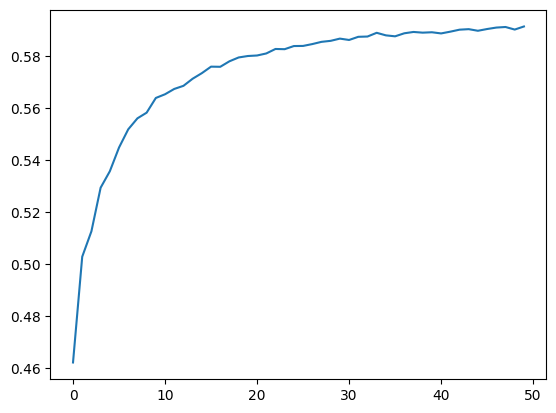

In [ ]:
path ="/Visual-question-answering-model/logs/2023-05-06_03:33:59.pth"
results = torch.load(path)
val_acc = torch.FloatTensor(results['tracker']['val_acc'])
val_acc = val_acc.mean(dim=1).numpy()
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_acc)
plt.savefig('val_acc.png')

In [ ]:
def prepare_questions(questions):
    '''
    Remove punctuation marks and spaces. Returns list
    '''
    questions = [questions]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')

def encode_question(question):
    '''
    Encode questions
    Get ids using vocabulary created using tokens during training
    '''
    vec = torch.zeros(len(question)).long()
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    token_to_index = vocab_json['question']
    for i, token in enumerate(question):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question)

def encode_img(net,img_path):
    '''
    Encoding input image using Resnet features. Resizes input image to config.image_size
    '''
    cudnn.benchmark = True
    transform = get_transform(config.image_size, config.central_fraction)
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    ix,iy = img.size()[1],img.size()[2]
    net = Net().cuda()
    net.eval()
    with torch.no_grad():
        img = Variable(img.cuda())
        out = net(img.view(1,3,ix,iy))
        features = out.data.cpu().numpy().astype('float16')
    return features

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence

import config


class Model_vqa(nn.Module):
    """ Re-implementation of ``Show, Ask, Attend, and Answer: A Strong Baseline For Visual Question Answering'' [0]

    [0]: https://arxiv.org/abs/1704.03162
    """

    def __init__(self, embedding_tokens):
        super(Model_vqa, self).__init__()
        question_features = 1024
        vision_features = config.output_features
        glimpses = 2

        self.text = TextProcessor(
            embedding_tokens=embedding_tokens,
            embedding_features=300,
            lstm_features=question_features,
            drop=0.5,
        )
        self.attention = Attention(
            v_features=vision_features,
            q_features=question_features,
            mid_features=512,
            glimpses=2,
            drop=0.5,
        )
        self.classifier = Classifier(
            in_features=glimpses * vision_features + question_features,
            mid_features=1024,
            out_features=config.max_answers,
            drop=0.5,
        )

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                init.xavier_uniform(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer , a


class Classifier(nn.Sequential):
    def __init__(self, in_features, mid_features, out_features, drop=0.0):
        super(Classifier, self).__init__()
        self.add_module('drop1', nn.Dropout(drop))
        self.add_module('lin1', nn.Linear(in_features, mid_features))
        self.add_module('relu', nn.ReLU())
        self.add_module('drop2', nn.Dropout(drop))
        self.add_module('lin2', nn.Linear(mid_features, out_features))


class TextProcessor(nn.Module):
    def __init__(self, embedding_tokens, embedding_features, lstm_features, drop=0.0):
        super(TextProcessor, self).__init__()
        self.embedding = nn.Embedding(embedding_tokens, embedding_features, padding_idx=0)
        self.drop = nn.Dropout(drop)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(input_size=embedding_features,
                            hidden_size=lstm_features,
                            num_layers=1)
        self.features = lstm_features

        self._init_lstm(self.lstm.weight_ih_l0)
        self._init_lstm(self.lstm.weight_hh_l0)
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()

        init.xavier_uniform(self.embedding.weight)

    def _init_lstm(self, weight):
        for w in weight.chunk(4, 0):
            init.xavier_uniform_(w)

    def forward(self, q, q_len):
        embedded = self.embedding(q)
        tanhed = self.tanh(self.drop(embedded))
        packed = pack_padded_sequence(tanhed, q_len, batch_first=True)
        _, (_, c) = self.lstm(packed)
        return c.squeeze(0)


class Attention(nn.Module):
    def __init__(self, v_features, q_features, mid_features, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_features, mid_features, 1, bias=False)  # let self.lin take care of bias
        self.q_lin = nn.Linear(q_features, mid_features)
        self.x_conv = nn.Conv2d(mid_features, glimpses, 1)

        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, v, q):
        v = self.v_conv(self.drop(v))
        q = self.q_lin(self.drop(q))
        q = tile_2d_over_nd(q, v)
        x = self.relu(v + q)
        x = self.x_conv(self.drop(x))
        return x


def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = F.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1)


def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return tiled


In [ ]:
!pip install --upgrade scikit-image

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import torch
import model

def demo(img_path,question):
    '''
    Main demo function. Takes input image path and Question string as input
    Returns top 5 answers, shows input image and visualizes attention applied 
    '''
    print('The Question asked was: ',question)
    cudnn.benchmark = True
    # Load pre-trained image
    log = torch.load('/Visual-question-answering-model/logs/2023-05-06_03:33:59.pth')
    tokens = len(log['vocab']['question']) + 1
    net = torch.nn.DataParallel(Model_vqa(tokens)).cuda()
    net.load_state_dict(log['weights'])
    net.eval()
    
    questions = list(prepare_questions(question))
    questions = [encode_question(q) for q in questions]
    q,q_len = questions[0]
    q = q.unsqueeze(0)

    v = encode_img(net,img_path)
    v = torch.from_numpy(v).to(torch.float)
    q_len = torch.tensor([q_len])
    with torch.no_grad():
        v = Variable(v)
        q = Variable(q)
        q_len = Variable(q_len)  
    
    out,att_out = net.forward(v,q,q_len)
    out = out.data.cpu()
    _, answer5 = torch.topk(out,5)
    answers = []
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    a_to_i = vocab_json['answer']
    for answer in answer5:
        answer = (answer.view(-1))
        for a in answer.data:
            answers.append(list(a_to_i.keys())[a.data])        
    print_answers(answers)
    visualize_attentn(att_out,img_path)
    return

def visualize_attentn(att_out,img_path):
    '''
    Takes output of attention layer and overlays on input image. Then shows both 
    '''
    att_out = att_out.view(-1,14,14)
    num_im = att_out.size()[0]
    im = Image.open(img_path)
    fig2,ax2 = plt.subplots(1)
    ax2.imshow(im)
    ax2.set_title('Original Image')
    ax2.axis('off')
    fig,axs = plt.subplots(1,num_im,figsize=(10,10))
    axs = axs.ravel()
    for i in range(0,num_im):
        a1 = att_out[i].cpu().detach()
        a1 = a1.numpy()
        a1 = skimage.transform.pyramid_expand(a1, upscale=64)
        im = im.resize(a1.shape)
        axs[i].imshow(im)
        axs[i].imshow(a1,cmap='gray',alpha=0.65)
        axs[i].set_title('Attention image '+str(i))
    for ax in axs:
        ax.axis('off')
    return

def print_answers(answers):
    '''
    Function to print top 5 answers
    '''
    for i,a in enumerate(answers):
        print("The top ",i+1," answer is ",a)
    return

The Question asked was:  who wearing green shirt


/tmp/ipykernel_2408/6107592.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/tmp/ipykernel_2408/6107592.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


The top  1  answer is  man
The top  2  answer is  no one
The top  3  answer is  nobody
The top  4  answer is  woman
The top  5  answer is  boy


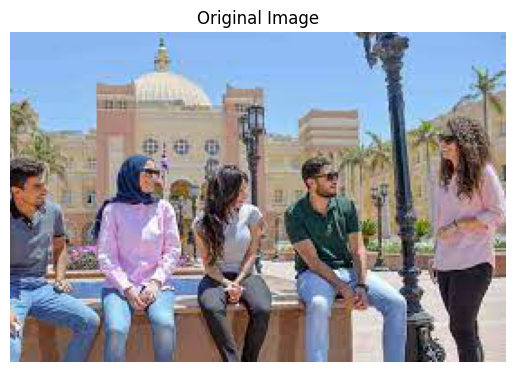

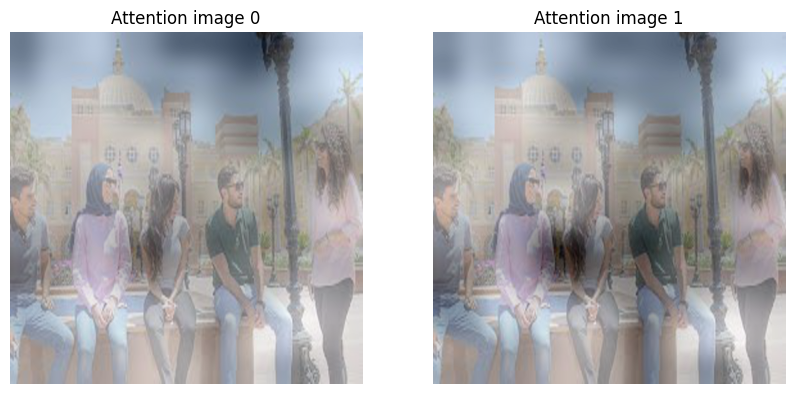

In [ ]:
demo('download.jpeg','who wearing green shirt')


The Question asked was:  What color is the chair?


/tmp/ipykernel_2408/6107592.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/tmp/ipykernel_2408/6107592.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


The top  1  answer is  blue
The top  2  answer is  brown
The top  3  answer is  black
The top  4  answer is  white
The top  5  answer is  gray


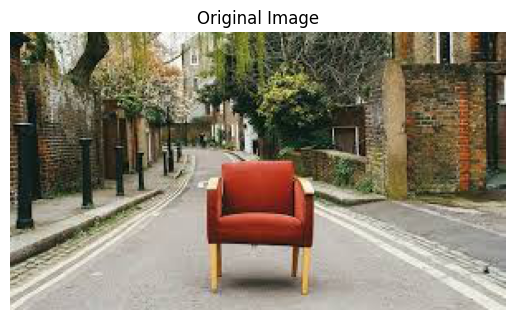

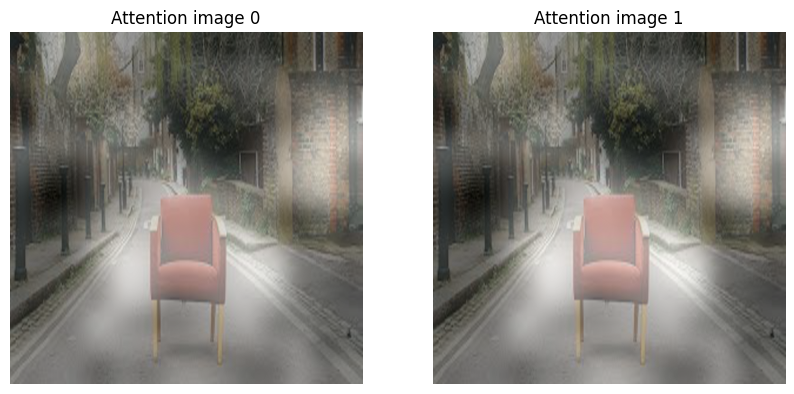

In [ ]:
demo('images.jpeg','What color is the chair?')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence

import config


class Net2(nn.Module):
    """ Re-implementation of ``Show, Ask, Attend, and Answer: A Strong Baseline For Visual Question Answering'' [0]
    [0]: https://arxiv.org/abs/1704.03162
    """

    def __init__(self, embedding_tokens):
        super(Net2, self).__init__()
        question_features = 1024
        vision_features = config.output_features
        glimpses = 2

        self.text = TextProcessor(
            embedding_tokens=embedding_tokens,
            embedding_features=300,
            lstm_features=question_features,
            drop=0.5,
        )
        self.attention = Attention(
            v_features=vision_features,
            q_features=question_features,
            mid_features=512,
            glimpses=2,
            drop=0.5,
        )
        self.classifier = Classifier(
            in_features=glimpses * vision_features + question_features,
            mid_features=1024,
            out_features=config.max_answers,
            drop=0.5,
        )

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)
        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer, a


class Classifier(nn.Sequential):
    def __init__(self, in_features, mid_features, out_features, drop=0.0):
        super(Classifier, self).__init__()
        self.add_module('drop1', nn.Dropout(drop))
        self.add_module('lin1', nn.Linear(in_features, mid_features))
        self.add_module('relu', nn.ReLU())
        self.add_module('drop2', nn.Dropout(drop))
        self.add_module('lin2', nn.Linear(mid_features, out_features))


class TextProcessor(nn.Module):
    def __init__(self, embedding_tokens, embedding_features, lstm_features, drop=0.0):
        super(TextProcessor, self).__init__()
        self.embedding = nn.Embedding(embedding_tokens, embedding_features, padding_idx=0)
        self.drop = nn.Dropout(drop)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(input_size=embedding_features,
                            hidden_size=lstm_features,
                            num_layers=1)
        self.features = lstm_features

        self._init_lstm(self.lstm.weight_ih_l0)
        self._init_lstm(self.lstm.weight_hh_l0)
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()

        init.xavier_uniform_(self.embedding.weight)

    def _init_lstm(self, weight):
        for w in weight.chunk(4, 0):
            init.xavier_uniform_(w)

    def forward(self, q, q_len):
        embedded = self.embedding(q)
        tanhed = self.tanh(self.drop(embedded))
        packed = pack_padded_sequence(tanhed, q_len, batch_first=True)
        _, (_, c) = self.lstm(packed)
        return c.squeeze(0)


class Attention(nn.Module):
    def __init__(self, v_features, q_features, mid_features, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_features, mid_features, 1, bias=False)  # let self.lin take care of bias
        self.q_lin = nn.Linear(q_features, mid_features)
        self.x_conv = nn.Conv2d(mid_features, glimpses, 1)

        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, v, q):
        v = self.v_conv(self.drop(v))
        q = self.q_lin(self.drop(q))
        q = tile_2d_over_nd(q, v)
        x = self.relu(v + q)
        x = self.x_conv(self.drop(x))
        return x


def apply_attention(input, attention):
    """ Apply any number of attention maps over the input. """
    n, c = input.size()[:2]
    glimpses = attention.size(1)

    # flatten the spatial dims into the third dim, since we don't need to care about how they are arranged
    input = input.view(n, 1, c, -1) # [n, 1, c, s]
    attention = attention.view(n, glimpses, -1)
    attention = F.softmax(attention, dim=-1).unsqueeze(2) # [n, g, 1, s]
    weighted = attention * input # [n, g, v, s]
    weighted_mean = weighted.sum(dim=-1) # [n, g, v]
    return weighted_mean.view(n, -1)


def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return 

In [ ]:
def prepare_questions(questions):
    '''
    Remove punctuation marks and spaces. Returns list
    '''
    questions = [questions]
    for question in questions:
        question = question.lower()[:-1]
        yield question.split(' ')

def encode_question(question):
    '''
    Encode questions
    Get ids using vocabulary created using tokens during training
    '''
    vec = torch.zeros(len(question)).long()
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    token_to_index = vocab_json['question']
    for i, token in enumerate(question):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question)

class Net(nn.Module):
    '''
    Loading Resnet pretrained model to get image features
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.model = caffe_resnet.resnet152(pretrained=True)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer


def encode_img(net,img_path):
    '''
    Encoding input image using Resnet features. Resizes input image to config.image_size
    '''
    cudnn.benchmark = True
    transform = get_transform(config.image_size, config.central_fraction)
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    ix,iy = img.size()[1],img.size()[2]
    net = Net().cuda()
    net.eval()
    with torch.no_grad():
        img = Variable(img.cuda())
        out = net(img.view(1,3,ix,iy))
        features = out.data.cpu().numpy().astype('float32')
    return features

In [ ]:
def demo2(img_path,question):
    '''
    Main demo function. Takes input image path and Question string as input
    Returns top 5 answers, shows input image and visualizes attention applied 
    '''
    print('The Question asked was: ',question)
    cudnn.benchmark = True
    # Load pre-trained image
    # Download from https://github.com/snagiri/ECE285_Jarvis_ProjectA/releases/download/v1.0/50epoch.pth
    log = torch.load('/Visual-question-answering-model/MSCOCOVAL2014.pht')
    tokens = len(log['vocab']['question']) + 1
    net = Net2(tokens)
    net.load_state_dict(log['weights'])
    net.eval()
    
    questions = list(prepare_questions(question))
    questions = [encode_question(q) for q in questions]
    q,q_len = questions[0]
    q = q.unsqueeze(0)

    v = encode_img(net,img_path)
    v = torch.from_numpy(v).to(torch.float)
    q_len = torch.tensor([q_len])
    with torch.no_grad():
        v = Variable(v)
        q = Variable(q)
        q_len = Variable(q_len)  
    
    out,att_out = net.forward(v,q,q_len)
    out = out.data.cpu()
    _, answer5 = torch.topk(out,5)
    answers = []
    with open(config.vocabulary_path, 'r') as fd:
        vocab_json = json.load(fd)
    a_to_i = vocab_json['answer']
    for answer in answer5:
        answer = (answer.view(-1))
        for a in answer.data:
            answers.append(list(a_to_i.keys())[a.data])        
    print_answers(answers)
    visualize_attentn(att_out,img_path)
    return

def visualize_attentn(att_out,img_path):
    '''
    Takes output of attention layer and overlays on input image. Then shows both 
    '''
    att_out = att_out.view(-1,14,14)
    num_im = att_out.size()[0]
    im = Image.open(img_path)
    fig2,ax2 = plt.subplots(1)
    ax2.imshow(im)
    ax2.set_title('Original Image')
    ax2.axis('off')
    fig,axs = plt.subplots(1,num_im,figsize=(10,10))
    axs = axs.ravel()
    for i in range(0,num_im):
        a1 = att_out[i].cpu().detach()
        a1 = a1.numpy()
        a1 = skimage.transform.pyramid_expand(a1, upscale=64)
        im = im.resize(a1.shape)
        axs[i].imshow(im)
        axs[i].imshow(a1,cmap='gray',alpha=0.65)
        axs[i].set_title('Attention image '+str(i))
    for ax in axs:
        ax.axis('off')
    return

def print_answers(answers):
    '''
    Function to print top 5 answers
    '''
    for i,a in enumerate(answers):
        print("The top ",i+1," answer is ",a)
    return

In [ ]:
demo2('download.jpeg','how many people are their')


The Question asked was:  how many people are their


TypeError: unsupported operand type(s) for +: 'Tensor' and 'NoneType'